In [3]:
import pandas as pd  # Data tables
import numpy as np   # Arrays/math
import matplotlib.pyplot as plt  # Visualizations
from statsmodels.tsa.stattools import adfuller  # Stationarity test (optional refresher)

import pymc as pm    # Bayesian modeling
import arviz as az   # Model diagnostics/plots

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
c:\Users\bezaw\OneDrive\Desktop\10Acadamy-KAIM\Week 11 challenge\brent-oil-change-point-analysis\venv\Lib\site-packages\arviz\__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


Load data

In [5]:
df = pd.read_csv('../data/BrentOilPrices.csv')
df['Date'] = pd.to_datetime(df['Date'])
print(df.head())  # Quick check: Should show 1987 start

C:\Users\bezaw\AppData\Local\Temp\ipykernel_12272\3197610254.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


        Date  Price
0 1987-05-20  18.63
1 1987-05-21  18.45
2 1987-05-22  18.55
3 1987-05-25  18.60
4 1987-05-26  18.63


Compute transforms (explain: Log price stabilizes variance;log returns make stationary for better modeling)

In [6]:
df['Log_Price'] = np.log(df['Price'])
df['Log_Return'] = df['Log_Price'] - df['Log_Price'].shift(1)
df = df.dropna()  # Drop first NaN

Subset to 2012-2022 (explain: Focuses on recent data-matches events, reduce MCMC compute time from 9000+ to ~2500 rows)

Subset shape: (2760, 4)


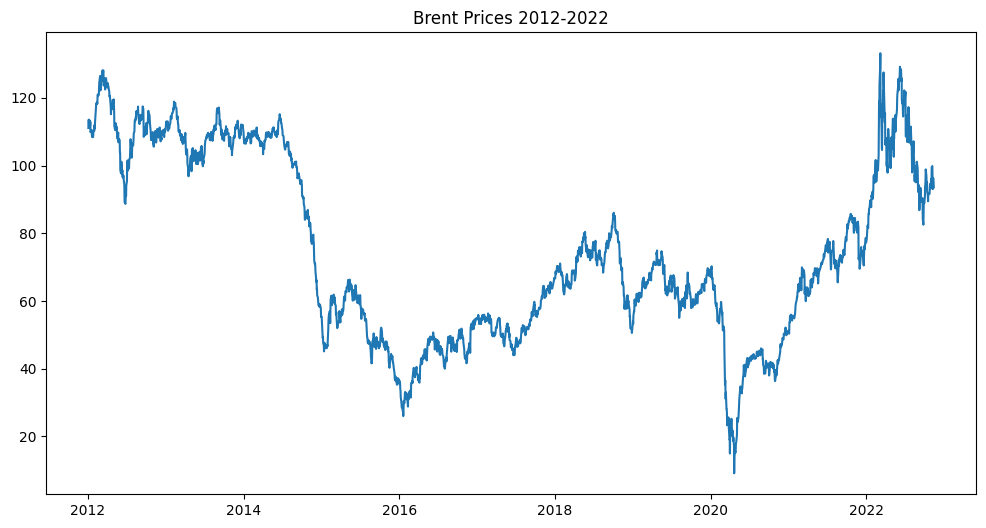

In [ ]:
df_recent = df[(df['Date'] >= '2012-01-01') & (df['Date'] <= '2022-12-31')].copy()
df_recent.reset_index(drop=True, inplace=True)  # New index 0 to len-1 for tau
print(f'Subset shape: {df_recent.shape}')  # ~ (2500+, 5 columns)
plt.figure(figsize=(12,6))
plt.plot(df_recent['Date'], df_recent['Price'])
plt.title('Brent Prices 2012-2022')
plt.show()  